In [28]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import re
import random
from random import randint
from nltk.stem import PorterStemmer
porter = PorterStemmer()
import json
import re
import nltk
from nltk.tokenize import sent_tokenize
import numpy as np
nltk.download('punkt')
from google.colab import drive
drive.mount('/content/drive')
import pandas  as pd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
passage_ids=pd.read_csv("/content/drive/MyDrive/passage_ids.csv")
df=pd.read_csv("/content/drive/MyDrive/Squad_PreProcessed.csv")
passage_ids.set_index("id",inplace=True)
def getsent(x):
    sent=sent_tokenize(passage_ids.loc[x].values[0])
    return str(sent)

df["sentences"]=df["passage_id"].apply(lambda x : getsent(x))

In [30]:
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [32]:
# embedding = model.encode(sentence)
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)

    if norm_vector1 == 0 or norm_vector2 == 0:
        return 0  # To handle zero vectors

    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

def prepare_dataset(df):
    req=df[["question","sentences","CorrectSentence"]]
    vals=req.values
    ma=0
    for i in range(len(vals)):
        se=eval(vals[i][1])
        ma=max(len(se),ma)
    dataset=np.zeros((10000,ma,2,384))
    qns=model.encode(vals[:10000,0])
    for i in range(len(dataset)):
      se=eval(vals[i][1])
      dataset[i,:len(se),1]=model.encode(se)
      dataset[i,:,0]=qns[i]
      print(i)
    return dataset



sentences=prepare_dataset(df)


Streaming output truncated to the last 5000 lines.
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189

In [33]:
x=sentences.reshape(sentences.shape[0]*sentences.shape[1],sentences.shape[2],sentences.shape[3])
labels=df["CorrectSentence"].values[:10000]
ylabels=np.zeros(sentences.shape[0]*sentences.shape[1])
iter=0
for i in range(len(sentences)):
  for j in range(len(sentences[i])):
    if(labels[i]==j):
      ylabels[iter]=1

    iter+=1

In [34]:
x.shape

(270000, 2, 384)

In [35]:
inp=Input(shape=x[0].shape)
flat=Flatten()(inp)
l1=Dense(64, activation='relu')(flat)
l2=Dense(64, activation='relu')(l1)
fin=Dense(1,activation="sigmoid")(l2)
model=Model(inputs=inp,outputs=fin)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2, 384)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                49216     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 53441 (208.75 KB)
Trainable params: 53441 (208.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
def generate_batch(X = x, y = ylabels, batch_size = 200):
  ''' Generate a batch of data '''
  while True:
    for j in range(0, len(X)-batch_size, batch_size):
      yield(X[j:j+batch_size],ylabels[j:j+batch_size])



In [37]:
batch_size = 100
epochs = 20
sep=int(0.9*len(x))
xtrain,xtest,ytrain,ytest=x[:sep],x[sep:],ylabels[:sep],ylabels[sep:]
history=model.fit_generator(generator = generate_batch(xtrain, ytrain, batch_size = batch_size),
                    steps_per_epoch =len(xtrain)//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(xtest, ytest, batch_size = batch_size),
                    validation_steps = len(ytest)//batch_size)

Epoch 1/20


<ipython-input-37-efd809328c41>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator = generate_batch(xtrain, ytrain, batch_size = batch_size),


2430/2430 [==============================] - 14s 5ms/step - loss: 0.0975 - accuracy: 0.9624 - val_loss: 0.1496 - val_accuracy: 0.9615
Epoch 2/20
2430/2430 [==============================] - 11s 5ms/step - loss: 0.0784 - accuracy: 0.9644 - val_loss: 0.1762 - val_accuracy: 0.9495
Epoch 3/20
2430/2430 [==============================] - 11s 4ms/step - loss: 0.0689 - accuracy: 0.9681 - val_loss: 0.1987 - val_accuracy: 0.9355
Epoch 4/20
2430/2430 [==============================] - 11s 4ms/step - loss: 0.0615 - accuracy: 0.9720 - val_loss: 0.2378 - val_accuracy: 0.9339
Epoch 5/20
2430/2430 [==============================] - 12s 5ms/step - loss: 0.0550 - accuracy: 0.9752 - val_loss: 0.2636 - val_accuracy: 0.9339
Epoch 6/20
2430/2430 [==============================] - 11s 5ms/step - loss: 0.0505 - accuracy: 0.9781 - val_loss: 0.2786 - val_accuracy: 0.9326
Epoch 7/20
2430/2430 [==============================] - 10s 4ms/step - loss: 0.0457 - accuracy: 0.9800 - val_loss: 0.3188 - val_accuracy: 0.9

In [38]:
pred=model.predict(xtest)
pred=pred.reshape(pred.shape[0]//27,27,1)
ydum=ytest.reshape(ytest.shape[0]//27,27)
acc=0
ypred=[]
for i in range(len(pred)):
  probs=pred[i]
  ind=np.argmax(probs)
  ypred.append(ind)

  if(np.argmax(ydum[i])==ind):
    acc+=1



print(acc,len(pred))

844/844 [==============================] - 2s 2ms/step
625 1000


In [39]:
yorig=[]
for i in range(len(ydum)):
  yorig.append(np.argmax(ydum[i]))

8

In [40]:
from sklearn.metrics import confusion_matrix
cnf=confusion_matrix(np.array(yorig), ypred)

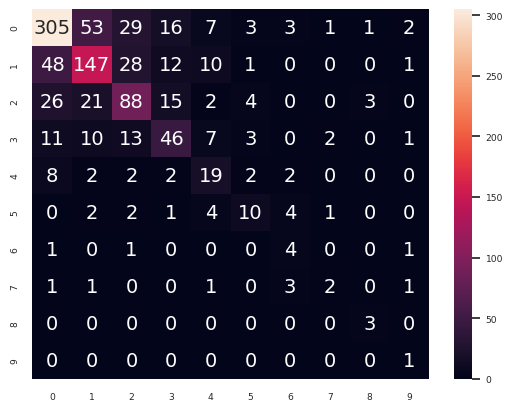

In [41]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(cnf, range(len(cnf)), range(len(cnf)))
# plt.figure(figsize=(10,7))
sn.set(font_scale=0.6) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14},fmt='g') # font size

plt.show()

In [49]:
from sklearn.metrics import f1_score
f1_score(yorig,ypred,average="weighted")

0.629200799530358

In [53]:
from sklearn.metrics import precision_score
precision_score(yorig,ypred,average="weighted")

0.6371155397500673

In [56]:
from sklearn.metrics import recall_score
recall_score(yorig,ypred,average="weighted")

0.625